In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp

from photocatalysis.learners_treesearch import get_unique_population, get_population_completed, generate_ml_vectors, get_ML_model
from sklearn.metrics import mean_absolute_error

In [2]:
### For automatically reloading import modules... allows you to run changes to code in jupyter without having to reload
%load_ext autoreload
%autoreload 2

## Active Learning

## Evaluation Parameters
1. Vertical IP
    Correlating with adiabtic IPs obtained from DFT would be nice. Since we're not looking at IPs in isolation, but rather comparing them with dGmax, 
    mixing two different levels of theory may introduce errors?
2. Loose relaxtion of adsorbate configurations
3. ZPE-TS of 2 configurations making up the rate determining step
4. IP, RDG would then form the basis of the acquistion function in the active learning phase

## Learning Parameters
1. Nbatch = 50
2. k = 0, 1
3. two_fold = No
4. reduction_of_search_space = No

initial population (179 unique mols) same as used in christians Active Learning paper

Results will depend on the hyperparameters chosen above...

----

In [3]:
# main_frame = pd.read_json('/home/btpq/bt308495/Thesis/df_initial_gfn1_testspace_photocatalysis.json', orient='split')
main_frame = pd.read_json('/home/btpq/bt308495/Thesis/run/df_population_runstep10.json', orient='split')
main_frame_1 = pd.read_json('/home/btpq/bt308495/Thesis/run/df_population_runstep7_kappa1.json', orient='split') #kappa=1
# main_frame = pd.read_json('/home/btpq/bt308495/Thesis/run/df_population_runstep10.json', orient='split')

# Get completed only
main_frame = get_population_completed(main_frame)
main_frame_1 = get_population_completed(main_frame_1)

train : upto generation 2
test : rest

train : upto generation 3
test : rest

etc.

In [4]:
mip, mrdg = [], []
rips, rrdgs = [], []
for round_added in range(main_frame.generation.min(), main_frame.generation.max()):
    print('Learning Step:', round_added)
    training_frame = main_frame.loc[main_frame.generation <= round_added]
    test_frame = main_frame.loc[main_frame.generation > round_added]
    test_frame_uniq = get_unique_population(get_population_completed(test_frame))

    # Get test data
    Xtest = generate_ml_vectors(test_frame_uniq).morgan_fp_bitvect.values

    # Fit Model on training data
    gpr_ip, xtrain_ip, _ = get_ML_model(training_frame, 'IP')
    gpr_rdg, xtrain_rdg, _ = get_ML_model(training_frame, 'dGmax')

    # Predict on test data
    yip_true = test_frame_uniq.IP.values
    yrdg_true = test_frame_uniq.dGmax.values

    yip, stdip = gpr_ip.predict(Xtest, return_std=True)
    yrdg, stdrdg = gpr_rdg.predict(Xtest, return_std=True)

    # Evaluate Performace
    mad_ip = mean_absolute_error(yip_true, yip) # MAD
    
    mad_rdg = mean_absolute_error(yrdg_true, yrdg)

    rip = yip_true - yip # residuals
    rrdg = yrdg_true - yrdg
    
    # store
    mip.append(mad_ip), mrdg.append(mad_rdg), rips.append(rip), rrdgs.append(rrdg)

Learning Step: 1

Fitting property: IP
Size of fitting set for ML model (_get_ML_model): 8
Pbounds {'c': (0.1, 3.0), 'rbf': (1.0, 1.0), 'alpha': (0.001, 1.0)}

initial guess [1.0, 1.0, 0.1]
Local (L-BFGS-B) opt 0 finished 11.353684432615342 [0.1        1.         0.99555448]

initial guess [1.3093638136374646, 1.0, 0.0011142604425275417]
Local (L-BFGS-B) opt 1 finished 11.35368443261503 [0.1        1.         0.99555474]

initial guess [0.9767644606323352, 1.0, 0.093246256174029]
Local (L-BFGS-B) opt 2 finished 11.353684432616753 [0.1        1.         0.99555422]

initial guess [0.6401546129952456, 1.0, 0.39737070675643926]
Local (L-BFGS-B) opt 3 finished 11.353684432615763 [0.1      1.       0.995555]

initial guess [1.6625685286097351, 1.0, 0.6855342808963627]
Local (L-BFGS-B) opt 4 finished 11.353684432615045 [0.1        1.         0.99555476]
Best solution after local opt: 11.35368443261503 [0.1        1.         0.99555474]
{'c': (0.1, 3.0), 'rbf': (1.0, 1.0), 'alpha': (0.001, 1.

In [ ]:
# rips_abs = [np.abs(r) for r in rips]
# rrdgs_abs = [np.abs(r) for r in rrdgs]

# fig, ax = plt.subplots(1, 2)
# sns.violinplot(data=rips_abs, bw='silverman', orient='v', color='C0',scale='width', width=0.8,  inner=None, ax=ax[0])
# sns.violinplot(data=rrdgs_abs, bw='silverman', orient='v', color='orange',scale='width', width=0.8,  inner=None, ax=ax[1])
# ax[0].plot(mip, 'k')
# ax[1].plot(mrdg, 'k')

### Learner is becoming more accurate as we have more samples to train with each generation

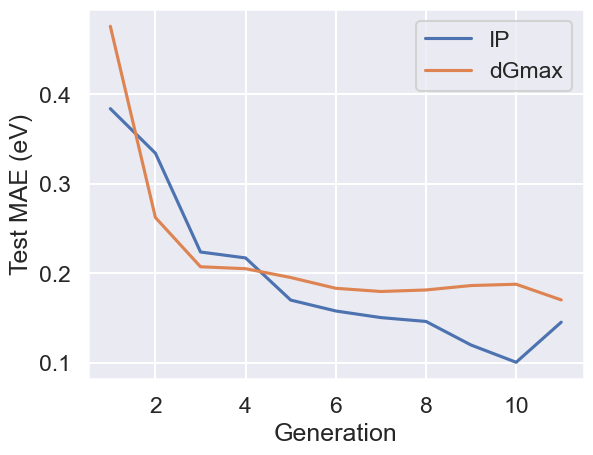

In [5]:
plt.xlabel('Learning Step')
plt.ylabel('Test MAE (eV)')
plt.xlabel('Generation')
x = [i for i in range(1, len(mip)+1)]
plt.plot(x, mip, label='IP')
plt.plot(x, mrdg, label='dGmax')
plt.legend()

GPR model is fitting IP better than dGmax

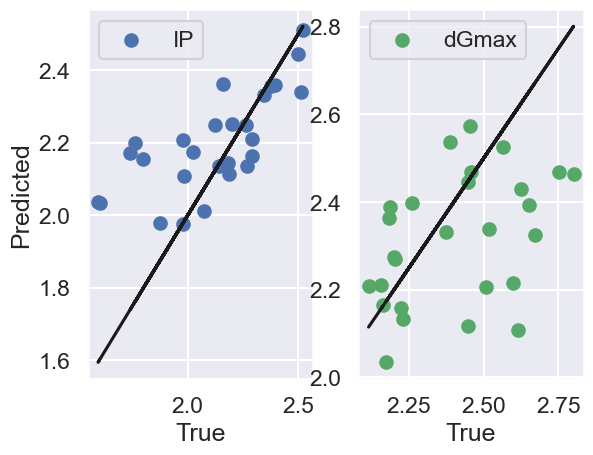

In [6]:
fig, ax = plt.subplots(1, 2)

ax[0].scatter(yip_true, yip, label='IP')
ax[0].plot(yip_true, yip_true, 'k')
ax[0].set_ylabel('Predicted')
ax[0].set_xlabel('True')

ax[1].scatter(yrdg_true, yrdg, label='dGmax', color='g')
ax[1].plot(yrdg_true, yrdg_true, 'k')
ax[1].set_xlabel('True')

ax[0].legend()
ax[1].legend()


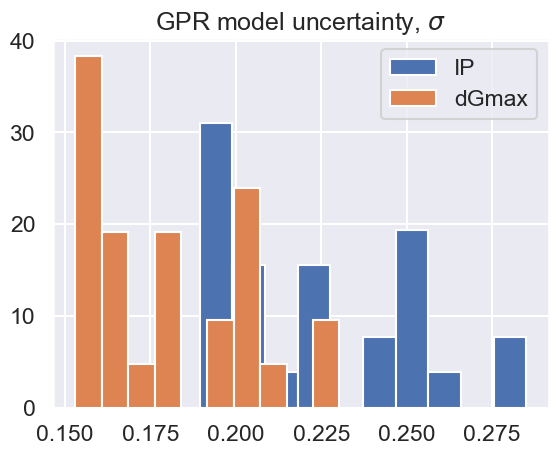

In [7]:
plt.title("GPR model uncertainty, $\sigma$")
plt.hist(stdip, label='IP', density=True)
plt.hist(stdrdg, label='dGmax', density=True)
plt.legend()

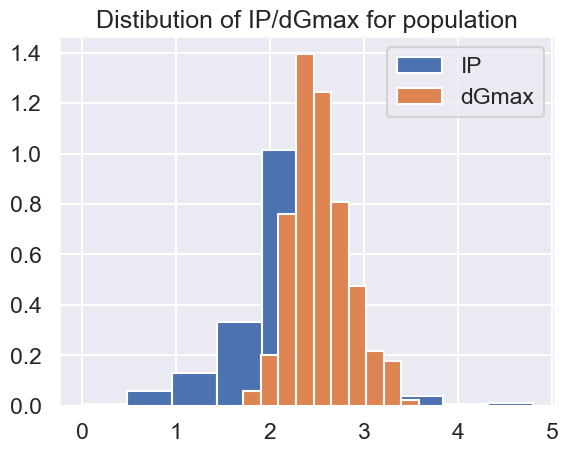

In [8]:
plt.title('Distibution of IP/dGmax for population')
plt.hist(main_frame.IP.values, density=True, label='IP')
plt.hist(main_frame.dGmax.values, density=True, label='dGmax')
plt.legend()

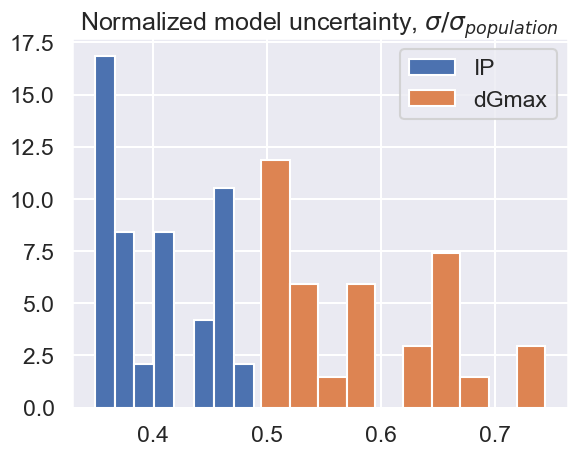

In [9]:
plt.title('Normalized model uncertainty, $\sigma / \sigma_{population}$ ')
plt.hist(stdip/np.nanstd(main_frame.IP.values), label='IP', density=True)
plt.hist(stdrdg/np.nanstd(main_frame.dGmax.values), label='dGmax', density=True)
plt.legend()

Perhaps the predictions are only good because theres little variation in dGmax from catalyst to catalyst....

Reasoning: Fingerprints, IP non-local, dGmax local?

Perhaps there some way to impove the modelling of dGmax?

In [ ]:
# xx = [i for i in range(1, len(mip)+2)]
# utilities_by_round = [df.utility_function for j, df in main_frame.groupby('generation')]
# med_utility_by_round = [np.nanmedian(u) for u in utilities_by_round]

# good_candidates_per_generation = [df.loc[df.utility_function > 0].shape[0] for j, df in main_frame.groupby('generation')]

<Axes: xlabel='generation', ylabel='utility_function'>

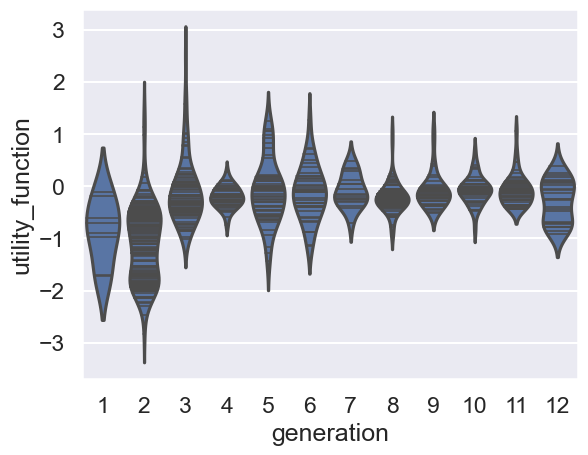

In [10]:
sns.violinplot(data=main_frame, x='generation', y='utility_function', bw='silverman', orient='v', color='C0',scale='width', width=0.8,  inner='stick')

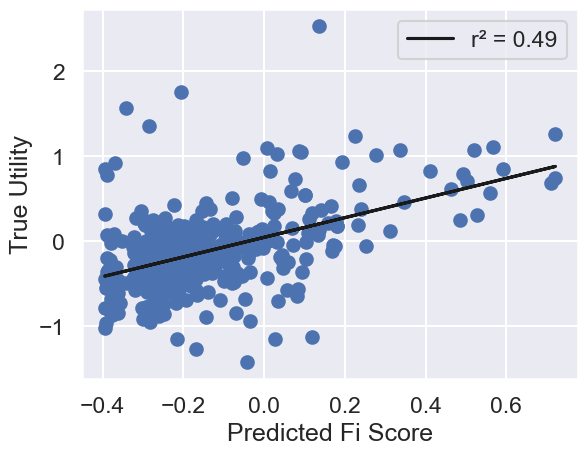

In [11]:
utils = main_frame.loc[~main_frame.Fi_scores.isna(), ['Fi_scores', 'utility_function']]

m, b, r_value, p_value, std_err = sp.stats.linregress(utils.values[:, 0], utils.values[:, 1])
plt.scatter(utils.values[:, 0], utils.values[:, 1])
plt.plot(utils.values[:, 0], m * utils.values[:, 0] + b, c='k', label='r\u00b2 = {}'.format(round(r_value, 2)))
plt.xlabel('Predicted Fi Score')
plt.ylabel('True Utility')
plt.legend()

Best performing molecules of each generation

In [12]:
from rdkit.Chem import Draw
from rdkit import Chem

In [13]:
smiles = []
mols = []
ls = []
for j, df in main_frame.groupby('generation'):
    df_sel = df.loc[df.utility_function == df.utility_function.max()].copy()
    smile = df_sel.molecule_smiles.values[0]
    mol = Chem.MolFromSmiles(smile)

    smiles.append(smile)
    mols.append(mol)
    # ls.append('Gen{} || {} || {} || {} ||'.format(j, round(df_sel.IP.values[0], 3), round(df_sel.dGmax.values[0], 3), round(df_sel.utility_function.values[0], 3)))
    ls.append('Gen{} || {} '.format(j, round(df_sel.utility_function.values[0], 3)))

    # df_sel.molecule_smiles, df_sel.IP, df_sel.dGmax, df_sel.utility_function

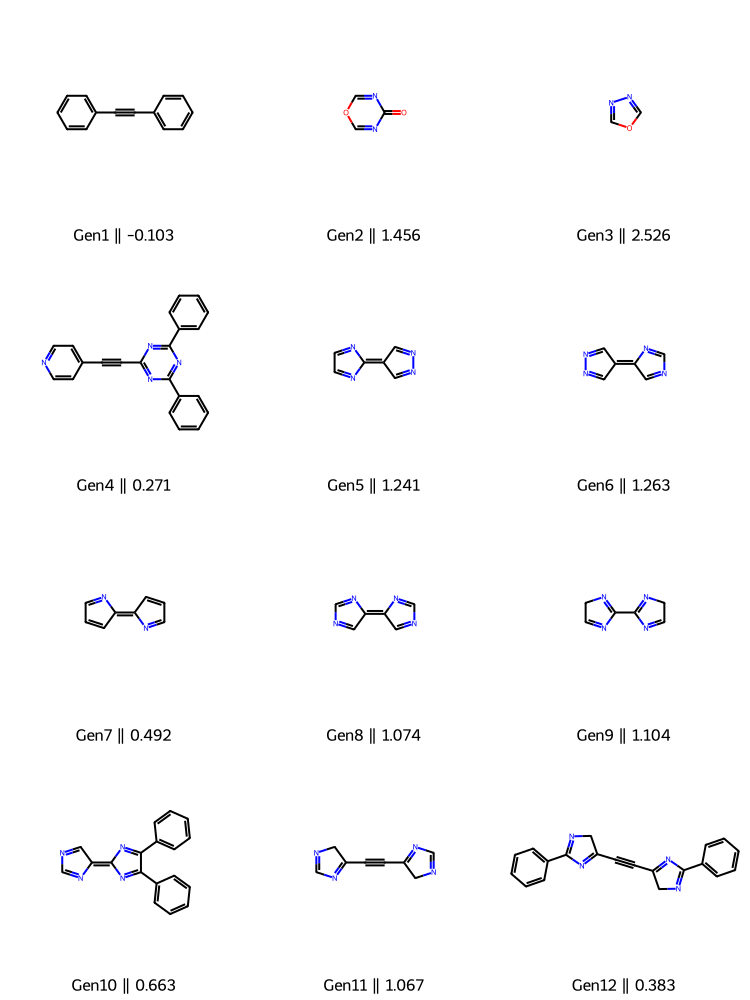

In [14]:
Draw.MolsToGridImage(mols,
                     legends=ls,
                     #highlightAtomLists=equivalent_atoms_list,
                     subImgSize=(250,250))

In [15]:
h = main_frame.loc[main_frame.utility_function > 0].shape[0] / main_frame.shape[0]
print('Fraction predicted to split water:', h)

Fraction predicted to split water: 0.2213855421686747


Kappa = 1

In [16]:
mip1, mrdg1 = [], []
rips1, rrdgs1 = [], []
for round_added in range(main_frame_1.generation.min(), main_frame_1.generation.max()):
    print('Learning Step:', round_added)
    training_frame = main_frame_1.loc[main_frame_1.generation <= round_added]
    test_frame = main_frame_1.loc[main_frame_1.generation > round_added]
    test_frame_uniq = get_unique_population(get_population_completed(test_frame))

    # Get test data
    Xtest = generate_ml_vectors(test_frame_uniq).morgan_fp_bitvect.values

    # Fit Model on training data
    gpr_ip, _, _ = get_ML_model(training_frame, 'IP')
    gpr_rdg, _, _ = get_ML_model(training_frame, 'dGmax')

    # Predict on test data
    yip_true = test_frame_uniq.IP.values
    yrdg_true = test_frame_uniq.dGmax.values

    yip, stdip = gpr_ip.predict(Xtest, return_std=True)
    yrdg, stdrdg = gpr_rdg.predict(Xtest, return_std=True)

    # Evaluate Performace
    mad_ip = mean_absolute_error(yip_true, yip) # MAD
    mad_rdg = mean_absolute_error(yrdg_true, yrdg)

    rip = yip_true - yip # residuals
    rrdg = yrdg_true - yrdg
    
    # store
    mip1.append(mad_ip), mrdg1.append(mad_rdg), rips1.append(rip), rrdgs1.append(rrdg)

Learning Step: 1

Fitting property: IP
Size of fitting set for ML model (_get_ML_model): 8
Pbounds {'c': (0.1, 3.0), 'rbf': (1.0, 1.0), 'alpha': (0.001, 1.0)}

initial guess [1.0, 1.0, 0.1]
Local (L-BFGS-B) opt 0 finished 11.353684432615342 [0.1        1.         0.99555448]

initial guess [1.3093638136374646, 1.0, 0.0011142604425275417]
Local (L-BFGS-B) opt 1 finished 11.35368443261503 [0.1        1.         0.99555474]

initial guess [0.9767644606323352, 1.0, 0.093246256174029]
Local (L-BFGS-B) opt 2 finished 11.353684432616753 [0.1        1.         0.99555422]

initial guess [0.6401546129952456, 1.0, 0.39737070675643926]
Local (L-BFGS-B) opt 3 finished 11.353684432615763 [0.1      1.       0.995555]

initial guess [1.6625685286097351, 1.0, 0.6855342808963627]
Local (L-BFGS-B) opt 4 finished 11.353684432615045 [0.1        1.         0.99555476]
Best solution after local opt: 11.35368443261503 [0.1        1.         0.99555474]
{'c': (0.1, 3.0), 'rbf': (1.0, 1.0), 'alpha': (0.001, 1.

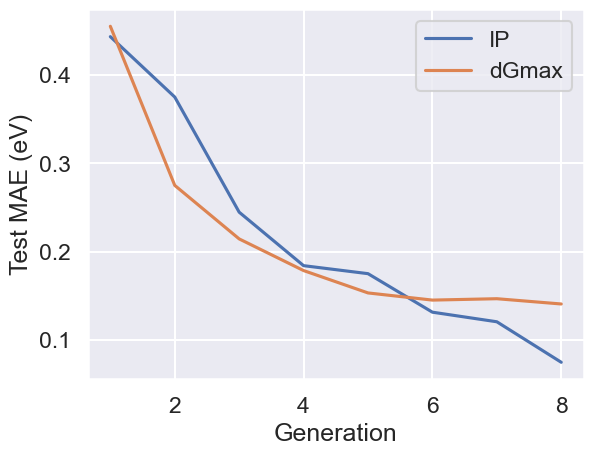

In [17]:
plt.xlabel('Learning Step')
plt.ylabel('Test MAE (eV)')
plt.xlabel('Generation')
x = [i for i in range(1, len(mip1)+1)]
plt.plot(x, mip1, label='IP')
plt.plot(x, mrdg1, label='dGmax')
plt.legend()

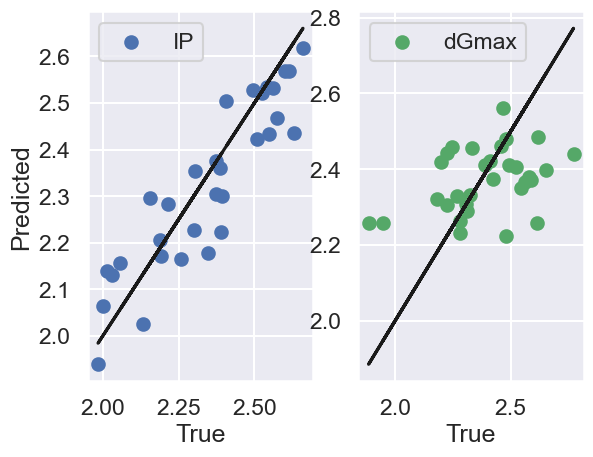

In [18]:
fig, ax = plt.subplots(1, 2)

ax[0].scatter(yip_true, yip, label='IP')
ax[0].plot(yip_true, yip_true, 'k')
ax[0].set_ylabel('Predicted')
ax[0].set_xlabel('True')

ax[1].scatter(yrdg_true, yrdg, label='dGmax', color='g')
ax[1].plot(yrdg_true, yrdg_true, 'k')
ax[1].set_xlabel('True')

ax[0].legend()
ax[1].legend()


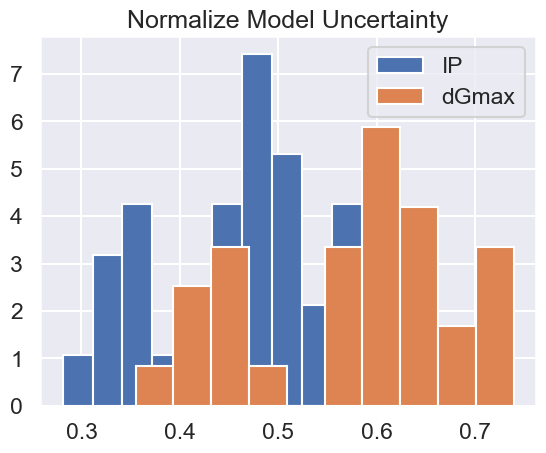

In [19]:
plt.title('Normalize Model Uncertainty')
plt.hist(stdip/np.nanstd(main_frame.IP.values), label='IP', density=True)
plt.hist(stdrdg/np.nanstd(main_frame.dGmax.values), label='dGmax', density=True)
plt.legend()

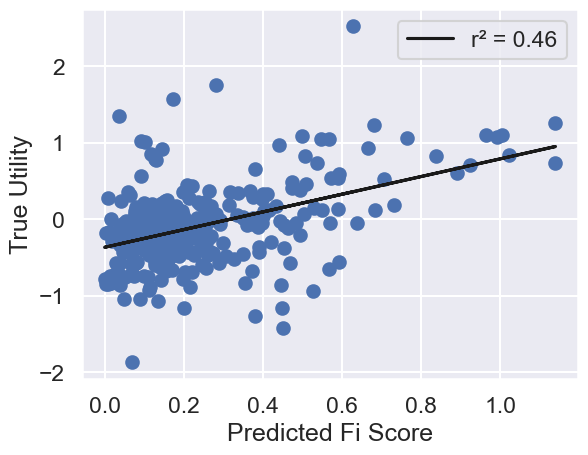

In [20]:
utils = main_frame_1.loc[~main_frame_1.Fi_scores.isna(), ['Fi_scores', 'utility_function']]

m, b, r_value, p_value, std_err = sp.stats.linregress(utils.values[:, 0], utils.values[:, 1])
plt.scatter(utils.values[:, 0], utils.values[:, 1])
plt.plot(utils.values[:, 0], m * utils.values[:, 0] + b, c='k', label='r\u00b2 = {}'.format(round(r_value, 2)))
plt.xlabel('Predicted Fi Score')
plt.ylabel('True Utility')
plt.legend()

<Axes: xlabel='generation', ylabel='utility_function'>

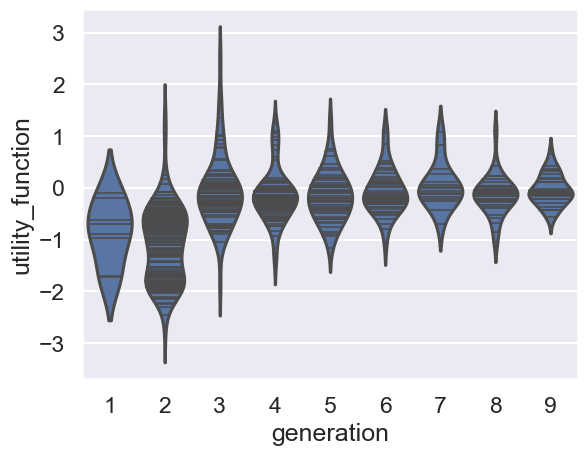

In [21]:
sns.violinplot(data=main_frame_1, x='generation', y='utility_function', bw='silverman', orient='v', color='C0',scale='width', width=0.8,  inner='stick')

In [24]:
smiles = []
mols = []
ls = []
for j, df in main_frame_1.groupby('generation'):
    df_sel = df.loc[df.utility_function == df.utility_function.max()].copy()
    smile = df_sel.molecule_smiles.values[0]
    mol = Chem.MolFromSmiles(smile)

    smiles.append(smile)
    mols.append(mol)
    # ls.append('Gen{} || {} || {} || {} ||'.format(j, round(df_sel.IP.values[0], 3), round(df_sel.dGmax.values[0], 3), round(df_sel.utility_function.values[0], 3)))
    ls.append('Gen{} || {} '.format(j, round(df_sel.utility_function.values[0], 3)))

    # df_sel.molecule_smiles, df_sel.IP, df_sel.dGmax, df_sel.utility_function

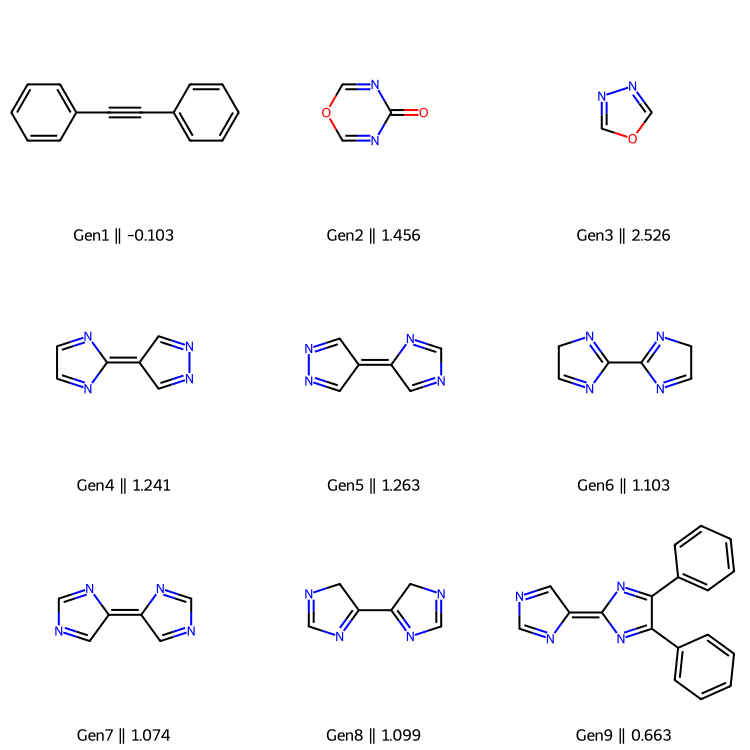

In [25]:
Draw.MolsToGridImage(mols,
                     legends=ls,
                     #highlightAtomLists=equivalent_atoms_list,
                     subImgSize=(250,250))

In [27]:
h = main_frame_1.loc[main_frame_1.utility_function > 0].shape[0] / main_frame.shape[0]
print('Fraction predicted to split water:', h)

Fraction predicted to split water: 0.18373493975903615


----

Questions/Next steps

1. Still need to do hyperparameter tuning, before submiting production run

2. Model performance and hyperparameter optimization (kappa, Nbatch, etc.) was done against a completely calculated population of 65,552 mols (xTB)
Discovery success S(N) was quantified, and a robust set of hyperparameters was chosen, to then be used on an unrestricted space and with DFT level theory.
    
    Should I be doing something similar here?

3. We may be plateuing in terms of Utility function... perhaps extending the possible set of morphing operations may help us explore better structures?

-----

In [ ]:
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
from photocatalysis.cheminformatics_fingerprint import get_tanimoto_distmat
from photocatalysis.adsorption.helpers import pairwise

In [ ]:
main_frame_morgan = generate_ml_vectors(main_frame_1)

In [ ]:
meds = []
for (j0, df0), (j1, df1) in pairwise(main_frame_morgan.groupby('generation')):
    X0 = df0.morgan_fp_bitvect.values
    X1 = df1.morgan_fp_bitvect.values
    sim_matrix = get_tanimoto_distmat(X0, X1)
    # unique_sims = sim_matrix[np.triu_indices(len(X), k=1)]

    med = np.median(sim_matrix)
    meds.append(med)

In [ ]:
meds

In [ ]:
plt.plot(meds)